## Image segmentation with SpaceNet

The goal of this notebook is to modify the [CamVID exercise on lesson 3 of Fast.ai course](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb) to predict building footprints on satellite images.

This was actually a competition in 2018 by [SpaceNet](https://spacenetchallenge.github.io/) so we are going to take all the needed data from there.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Get the data
As decribed on [this page](https://spacenetchallenge.github.io/), the data lives on `s3://spacenet-dataset/` with "requester pays" which means it's on a S3 AWS bucket that you pay when you download. To get all we need use 
```
aws s3 cp s3://spacenet-dataset/AOI_1_Rio/processedData/processedBuildingLabels.tar.gz .
```

Then I also normalize the data
```
cd processedBuildingLabels/vectordata/geojson
rename  -v  's/^(.{4})//' *
```
and
```
cd processedBuildingLabels/3band
rename  -v  's/^(.{4})//' *
```

In [3]:
path = Path()/'data/space/test/processedBuildingLabels'
path.ls()

[PosixPath('data/space/test/processedBuildingLabels/3band.tar'),
 PosixPath('data/space/test/processedBuildingLabels/vectordata'),
 PosixPath('data/space/test/processedBuildingLabels/geojson'),
 PosixPath('data/space/test/processedBuildingLabels/masks'),
 PosixPath('data/space/test/processedBuildingLabels/3band'),
 PosixPath('data/space/test/processedBuildingLabels/8band.tar.gz'),
 PosixPath('data/space/test/processedBuildingLabels/masks.txt')]

## Data

In [4]:
path_img = path/'3band'
path_img

PosixPath('data/space/test/processedBuildingLabels/3band')

In [5]:
fnames = get_image_files(path_img)
a=fnames[3]
a.name

'AOI_1_RIO_img3093.tif'

### burning footprints
Building footprints are in geojson format, so we need to burn them into a mask. The best way I've foundto do that is using rasterio, then wrap it with `parallel` to run it as fast as possible:
```
parallel -v 'rio rasterize --overwrite masks/{/.}.tif --like 3band/{/.}.tif < {}' ::: geojson/*.geojson
```

Some chips do not havy any building footprint, so we need to remove them:

In [6]:
import os.path
import os
n=0
for chip in fnames:
    mask=path/'masks'/chip.name
    if not os.path.isfile(mask) :
        n=n+1
        print("removed empty chip",chip)
        os.remove(chip)
n

0

In [59]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/space/test/processedBuildingLabels/3band/AOI_1_RIO_img3138.tif'),
 PosixPath('data/space/test/processedBuildingLabels/3band/AOI_1_RIO_img2633.tif'),
 PosixPath('data/space/test/processedBuildingLabels/3band/AOI_1_RIO_img1851.tif')]

In [8]:
get_y_fn = lambda x: path.as_posix()+f'/masks/{x.stem}.tif'

In [ ]:
img_f = path_img/fnames[1].name
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f))

_,axs = plt.subplots(1,3, figsize=(16,8))
img.show(ax=axs[0], title='Satellite Image')
img.show(ax=axs[1], y=mask, title='Satellite buildings masked')
mask.show(ax=axs[2], title='Buildings mask only', alpha=1.)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([406, 439]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [11]:
codes = np.loadtxt(path/'masks.txt', dtype=str); codes

array(['not-building', 'building'], dtype='<U12')

## Datasets

In [12]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
    
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 3418MB of GPU RAM free


In [13]:
src = (SegmentationItemList.from_folder(path_img) #Get all the images
       .split_by_rand_pct()                       #Split into train and validation
       .label_from_func(get_y_fn, classes=codes)) #Add labels to both with a function

In [14]:
#To start we will use very small images and large batch sizes, to be quick and try to learn from small images.
size = 224//4 #src_size//2
bs=10
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

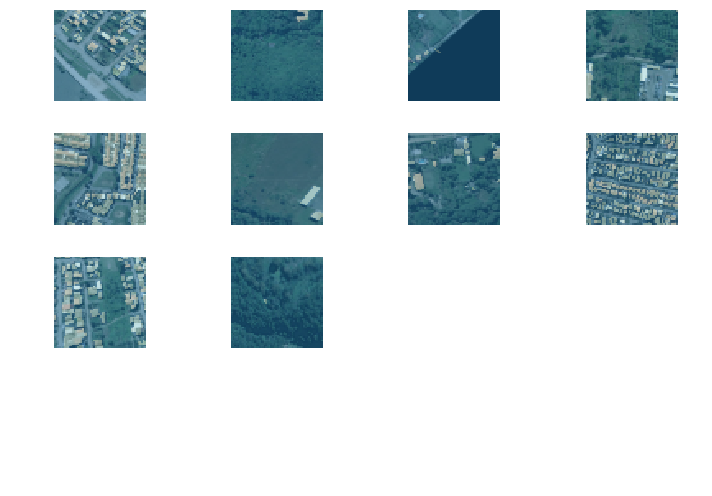

In [15]:
data.show_batch(6, figsize=(10,7))

## Model

In [14]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target 
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [15]:
metrics=acc_camvid
# metrics=accuracy

In [16]:
wd=1e-2

In [19]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


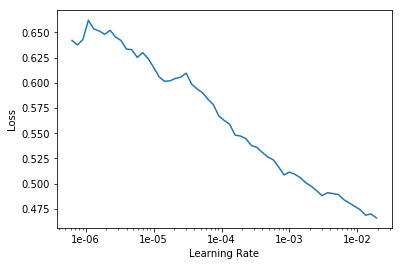

In [20]:
lr_find(learn)
learn.recorder.plot()

In [21]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.258860,0.235136,0.895312,00:37
1,0.245629,0.221333,0.905907,00:37
2,0.229885,0.207152,0.910855,00:36
3,0.229688,0.206537,0.911951,00:36
4,0.239188,0.224946,0.907892,00:36
5,0.228804,0.206170,0.912370,00:36
6,0.207158,0.202211,0.913044,00:35
7,0.212620,0.206558,0.913900,00:37
8,0.207865,0.199788,0.919002,00:40
9,0.190656,0.188601,0.920367,00:38


In [22]:
learn.save('stage-1-bs10-size56')

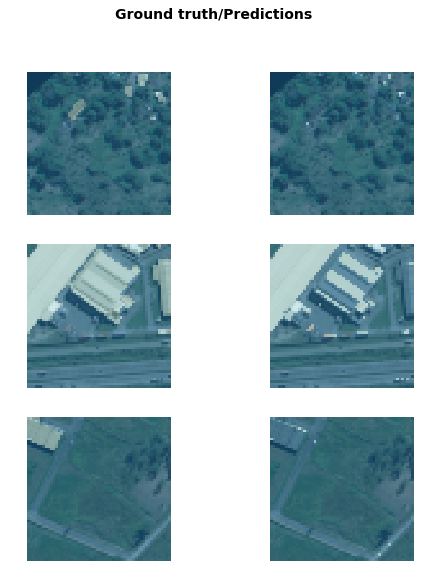

In [27]:
learn.show_results(rows=3, figsize=(8,9))

let's double the size of the images and continue trainning.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


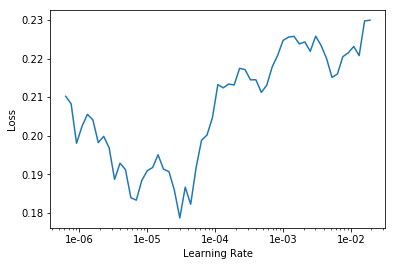

In [27]:
size = 224//2
bs=2
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16() 
learn.load('stage-1-bs10-size56')
lr_find(learn)
learn.recorder.plot()


In [28]:
lr=8e-4
learn.fit_one_cycle(4, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.193259,0.183299,0.919859,03:26
1,0.201794,0.178201,0.921780,03:26
2,0.207514,0.179210,0.921296,03:25
3,0.191713,0.172408,0.924480,03:25


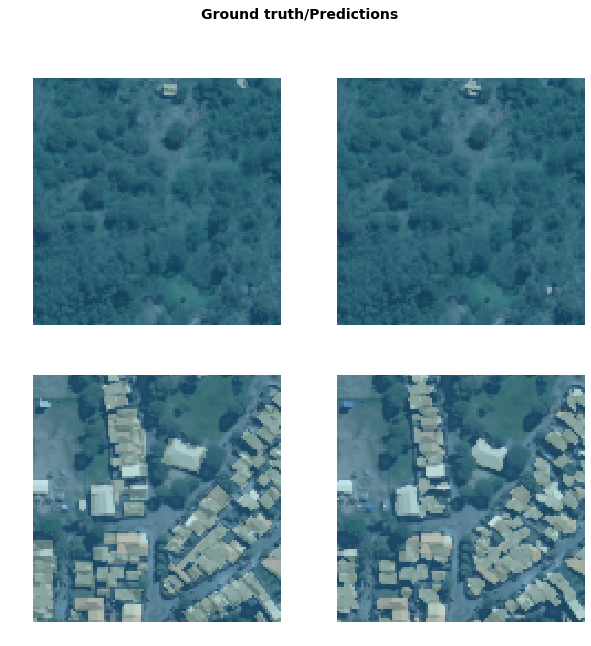

In [35]:
learn.show_results(rows=2, figsize=(10,10))

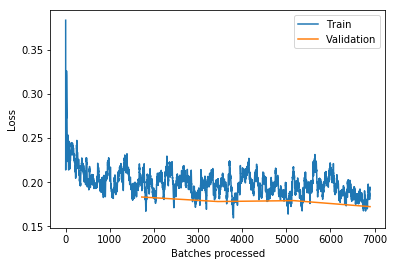

In [36]:
learn.recorder.plot_losses()

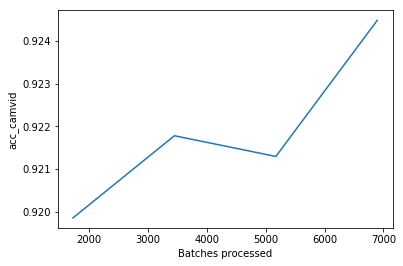

In [37]:
learn.recorder.plot_metrics()

In [38]:
learn.save('stage-1-int-bs2-size112')

In [42]:
learn.unfreeze()

In [43]:
lrs = slice(lr/400,lr)

In [44]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.184547,0.175377,0.923323,04:06
1,0.182324,0.173266,0.923769,04:06
2,0.174315,0.172200,0.924629,04:07


In [49]:
learn.save('stage-2');

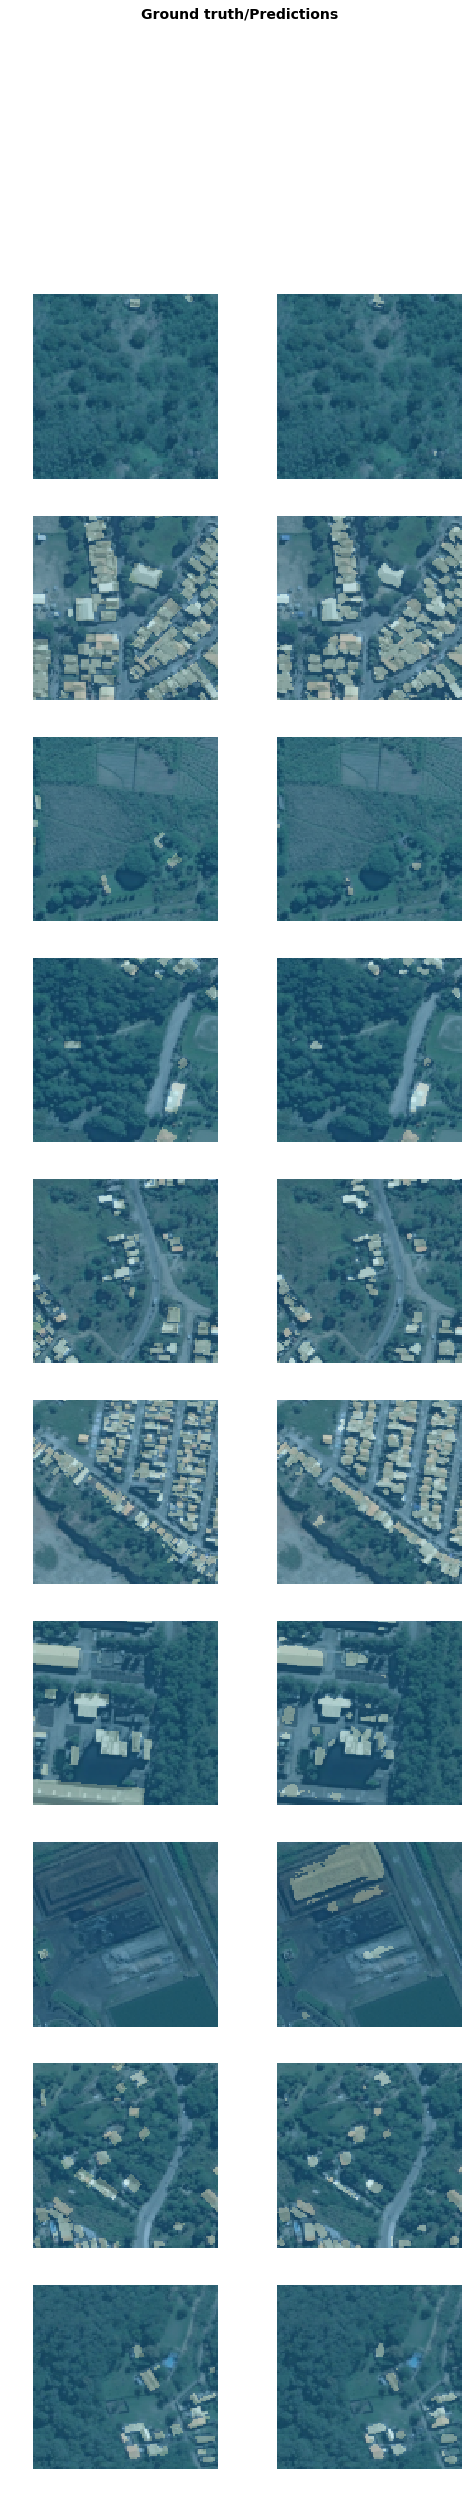

In [58]:
size = 224//2
bs=10
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16() 
learn.load('stage-2')
learn.show_results(ds_type=DatasetType.Valid,rows=10)